In [47]:
from setup_notebook import setup_project_path
setup_project_path()

In [48]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from datetime import datetime, date, timedelta
import os
import numpy as np
from scipy.stats import lognorm, loguniform, norm
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_validate
import boto3
from io import StringIO
pd.set_option('display.max_columns',100)

## Load Data

In [50]:
data_dir = PROCESSED_DATA_DIR
models_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [51]:
df_train_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_train_360_days.csv'))
df_test_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_test_360_days.csv'))
df_oov_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_360_days.csv'))

In [52]:
df_train_360[df_train_360.accounts_group=='2021-12_Uganda_SHS Entry-Level_Iganga_Sun King Home 120 EasyBuy']

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age
25702,2021-12_Uganda_SHS Entry-Level_Iganga_Sun King...,7,135.85894,371,0.156767,0.261685,0.33593,0.513145,0.711295,0.848832,0.903846,0.93038,0.941091,0.959834,2.4816,1.7976,1.4735,1.0799,0.9846,0.8754,0.9038,0.9303,0.941,0.9598,0.0,4.0,11.0,21.0,34.0,40.0,60.0,68.0,78.0,82.0,0.142857,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.142857,0.285714,0.428571,0.714286,0.857143,0.857143,0.857143,0.285714,0.285714,0.0,0.142857,0.0,0.142857,0.285714,0.142857,0.142857,0.142857,0.991967,1146.222065,1155.50423,2021-12,Uganda,SHS Entry-Level,Iganga,Sun King Home 120 EasyBuy,44,720


In [53]:
df_train_360.accounts_group.sample(frac=0.001).tolist()

['2021-04_Tanzania_Lanterns_Singida_Sun King Boom EasyBuy',
 '2021-03_Kenya_SHS Entry-Level_Moyale_Sun King Home 60 EasyBuy',
 '2020-11_Kenya_SHS with TV_Mombasa_Sun King Home 400 Easybuy GSM',
 '2020-02_Myanmar (Burma)_SHS without TV_Bogale_Sun King Home 400 Easybuy GSM',
 '2021-11_Kenya_SHS with TV_Mlolongo_Sun King Home 400 EasyBuy',
 '2018-10_Uganda_SHS Entry-Level_Nebbi_Sun King Home 120 EasyBuy',
 '2019-09_Kenya_SHS with TV_Saboti_Sun King Home 400 Easybuy GSM',
 '2020-09_Kenya_Lanterns_Iten_Sun King Pro EasyBuy',
 '2022-02_Kenya_SHS with TV Upgrade_Homa Bay_Sun King Home 600 Easybuy GSM',
 '2018-04_Uganda_SHS Entry-Level_Jinja_Sun King Home 60 EasyBuy',
 '2020-07_Tanzania_SHS Entry-Level_Dodoma_Sun King Home 120 EasyBuy',
 '2021-09_Tanzania_SHS Entry-Level_Mbagala_Sun King Home 120 EasyBuy',
 '2021-02_Tanzania_SHS Entry-Level_Shinyanga_Sun King Home 60 EasyBuy',
 '2018-12_Kenya_SHS with Stove_Maua_Sun King Home 60 EasyBuy',
 '2021-10_Kenya_SHS Entry-Level Upgrade_Mutomo_Sun King

In [54]:
df_test_360.shape

(8987, 84)

In [55]:
df_train_360.shape

(50926, 84)

In [56]:
df_train_360

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age
0,2017-06_Tanzania_SHS Entry-Level_Mwenge_Sun Ki...,10,168.480000,263,0.047897,0.121508,0.190714,0.360139,0.478849,0.544325,0.584802,0.599087,0.602659,0.626468,0.6668,0.6365,0.6153,0.5398,0.4788,0.5443,0.5848,0.5990,0.6026,0.6264,1.0,5.0,14.0,36.0,57.0,73.0,82.0,119.0,169.0,225.0,0.500000,0.300000,0.200000,0.200000,0.222222,0.250000,0.285714,0.285714,0.285714,0.285714,0.200000,0.300000,0.200000,0.300000,0.400000,0.600000,0.600000,0.600000,0.700000,0.600000,0.0,0.0,0.0,0.0000,0.100000,0.200000,0.300000,0.300000,0.300000,0.300000,0.400000,0.600000,0.300000,0.700000,0.500000,0.600000,0.700000,0.700000,0.700000,0.700000,0.641270,672.256179,1048.320020,2017-06,Tanzania,SHS Entry-Level,Mwenge,Sun King Home 60 EasyBuy,98,720
1,2020-06_Kenya_SHS Entry-Level_Kitale_Sun King ...,153,2156.752107,279,0.081915,0.154441,0.218723,0.389967,0.550020,0.665374,0.734274,0.782127,0.814607,NaN,0.9721,0.7953,0.7192,0.6152,0.5708,0.6653,0.7342,0.7821,0.8146,NaN,3.0,10.0,18.0,47.0,80.0,112.0,142.0,169.0,192.0,NaN,0.209150,0.111111,0.058824,0.032680,0.020979,0.026786,0.033333,0.039474,0.050847,NaN,0.013072,0.039216,0.071895,0.111111,0.117647,0.176471,0.150327,0.150327,0.169935,NaN,0.0,0.0,0.0,0.0000,0.065359,0.267974,0.411765,0.503268,0.614379,NaN,0.287582,0.294118,0.326797,0.418301,0.418301,0.418301,0.392157,0.372549,0.333333,NaN,0.868461,15337.383525,17660.417135,2020-06,Kenya,SHS Entry-Level,Kitale,Sun King Home 60 EasyBuy,62,630
2,2021-04_Nigeria_SHS with TV_Ado Ekiti_Sun King...,10,656.339560,378,0.086538,0.162500,0.239904,0.460096,0.608894,0.771875,0.836538,0.869231,0.911779,0.938702,1.9702,1.2868,1.1498,1.0096,0.8664,0.8126,0.8365,0.8692,0.9117,0.9387,0.0,2.0,5.0,12.0,36.0,54.0,77.0,113.0,132.0,142.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,0.100000,0.200000,0.100000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.200000,0.600000,0.600000,0.700000,0.800000,0.100000,0.100000,0.100000,0.300000,0.200000,0.200000,0.300000,0.100000,0.200000,0.100000,1.000000,5460.745200,5460.745200,2021-04,Nigeria,SHS with TV,Ado Ekiti,Sun King Home 600 Easybuy GSM,52,720
3,2018-02_Kenya_Lanterns_Kisii_Sun King Boom Eas...,16,170.640080,147,0.191952,0.315612,0.445077,0.707423,0.799133,0.840166,0.848202,0.853112,0.864656,0.868482,1.1684,0.8336,0.7507,0.7074,0.7991,0.8401,0.8482,0.8531,0.8646,0.8684,0.0,5.0,12.0,29.0,57.0,66.0,71.0,90.0,106.0,110.0,0.062500

## More Feature Engineering

In [57]:
def feature_engineering(df_train, df_test, df_oov):
    
    # Creating column for Unlock price
    df_train['unlock_price_usd'] = df_train['upfront_price_usd'] + df_train['total_follow_on_revenue_usd']
    df_test['unlock_price_usd'] = df_test['upfront_price_usd'] + df_test['total_follow_on_revenue_usd']
    df_oov['unlock_price_usd'] = df_oov['upfront_price_usd'] + df_oov['total_follow_on_revenue_usd']

    # Calculating averge unlock and upfront price

    df_train['avg_upfront_price_usd'] = np.round((df_train['upfront_price_usd']/df_train['count_units']),0)
    df_test['avg_upfront_price_usd'] = np.round((df_test['upfront_price_usd']/df_test['count_units']),0)
    df_oov['avg_upfront_price_usd'] = np.round((df_oov['upfront_price_usd']/df_oov['count_units']),0)
    
    df_train['avg_unlock_price_usd'] = np.round((df_train['unlock_price_usd']/df_train['count_units']),0)
    df_test['avg_unlock_price_usd'] = np.round((df_test['unlock_price_usd']/df_test['count_units']),0)
    df_oov['avg_unlock_price_usd'] = np.round((df_oov['unlock_price_usd']/df_oov['count_units']),0)

    # Removing unnecessary columns
    #cols_to_remove = [col for col in df_train.columns if ('repayment_speed_' in col)]
    cols_to_remove = []
    cols_to_remove.append('upfront_price_usd')
    cols_to_remove.append('unlock_price_usd')

    print('columns to remove: ',cols_to_remove)
    
    df_train.drop(cols_to_remove, axis=1, inplace=True)
    df_test.drop(cols_to_remove, axis=1, inplace=True)
    df_oov.drop(cols_to_remove, axis=1, inplace=True)
    
    print('Sample from train data------------')
    print(df_train.sample(1))
    
    print('Sample from test data------------')
    print(df_test.sample(1))

    df_train = df_train.reset_index().drop(columns = 'index')
    df_test = df_test.reset_index().drop(columns = 'index')
    df_oov = df_oov.reset_index().drop(columns = 'index')
    
    return df_train, df_test, df_oov

In [58]:
df_train, df_test, df_oov = feature_engineering(df_train_360, df_test_360, df_oov_360)

columns to remove:  ['upfront_price_usd', 'unlock_price_usd']
Sample from train data------------
                                         accounts_group  count_units  \
9229  2020-05_Tanzania_SHS with TV_Mbeya_Sun King Ho...           18   

      avg_planned_repayment_days    frr_30    frr_60    frr_90   frr_180  \
9229                         551  0.036414  0.076702  0.115147  0.221418   

       frr_270   frr_360   frr_450   frr_540   frr_630   frr_720  \
9229  0.303121  0.392769  0.480133  0.552496  0.607609  0.643437   

      repayment_speed_30  repayment_speed_60  repayment_speed_90  \
9229              0.8623              0.7882              0.7556   

      repayment_speed_180  repayment_speed_270  repayment_speed_360  \
9229               0.6971               0.6277                0.606   

      repayment_speed_450  repayment_speed_540  repayment_speed_630  \
9229               0.5903               0.5646               0.6076   

      repayment_speed_720  avg_cum_days_disab

In [ ]:
import pandas as pd
import numpy as np
from typing import List

BACKTEST_POINTS = [30,60,90,180,270,360,450,540,630,720]

prefixes = [
    "frr",
    "repayment_speed",
    "avg_cum_days_disabled",
    "at_risk_rate",
    "disabled_gt_two_week_rate",
    "unlocked_rate",
    "disabled_rate"
]

index_cols = [
    "accounts_group", "count_units", "avg_planned_repayment_days",
    "reg_month", "country", "product_group", "area", "primary_product",
    "age_in_months", "cohort_age", "avg_upfront_price_usd", "avg_unlock_price_usd"
]

replace_nan = -99.0   # value to fill masked-out future features with


def suffix_col(prefix: str, bt: int) -> str:
    return f"{prefix}_{bt}"

def all_feature_cols(prefixes: List[str], bts: List[int]) -> List[str]:
    cols = []
    for p in prefixes:
        for bt in bts:
            cols.append(suffix_col(p, bt))
    return cols

ALL_BT_COLS = all_feature_cols(prefixes, BACKTEST_POINTS)


def make_view(df: pd.DataFrame, max_bt: int, fill_replace_nan: float = replace_nan, override_cohort_age: bool = True):
    """
    Return a copy of df where features for backtesting points > max_bt are masked (set to replace_nan),
    and for each bt we add a presence flag column like `frr_present_450`.
    If override_cohort_age=True, set cohort_age = min(original, max_bt) to simulate the view.
    """
    df_view = df.copy(deep=True)

    # ensure all expected columns exist (if some missing in the raw df)
    for col in ALL_BT_COLS:
        if col not in df_view.columns:
            df_view[col] = np.nan

    # Add presence flags for each backtesting point (1 if that bt col is non-null and cohort_age >= bt)
    for bt in BACKTEST_POINTS:
        col_any = False
        for p in prefixes:
            if not df_view[suffix_col(p, bt)].isnull().all():
                col_any = True
                break

        flag_col = f"bt_present_{bt}"
        df_view[flag_col] = ((df_view["cohort_age"] >= bt) & col_any).astype(int)

    for bt in BACKTEST_POINTS:
        if bt > max_bt:
            for p in prefixes:
                c = suffix_col(p, bt)
                # mask value
                df_view[c] = df_view[c].fillna(fill_replace_nan)   # convert NaN to replace_nan too
                df_view.loc[:, c] = fill_replace_nan
        else:
            # ensure missing values within allowed bt are handled (fillna with replace_nan or better: keep NaN)
            # We recommend filling with replace_nan for LightGBM
            for p in prefixes:
                c = suffix_col(p, bt)
                df_view[c] = df_view[c].fillna(fill_replace_nan)

    # optionally override cohort_age to reflect the view (so the model sees 'age at view')
    if override_cohort_age:
        df_view["cohort_age"] = df_view["cohort_age"].clip(upper=max_bt)

    for sc in index_cols:
        if sc not in df_view.columns:
            df_view[sc] = np.nan

    feature_cols = index_cols + ALL_BT_COLS + [f"bt_present_{bt}" for bt in BACKTEST_POINTS]
    return df_view[feature_cols]


In [ ]:
# # assume `df` is your full dataframe (the sample rows you pasted)
# df = df_train.copy()

# # filter cohorts with real extended data available
# mask_has_450 = df["cohort_age"] >= 450
# df_with_450 = df[mask_has_450].reset_index(drop=True)

# # Construct the two views
# X450 = make_view(df_with_450, max_bt=450, fill_replace_nan=replace_nan, override_cohort_age=True)
# X360 = make_view(df_with_450, max_bt=360, fill_replace_nan=replace_nan, override_cohort_age=True)

# # target (true label) for training:
# y = df_with_450["frr_3_years"].values   # or "actual_fr" depending on training target

# print("X450.shape:", X450.shape)
# print("X360.shape:", X360.shape)
# print("y.shape:", y.shape)


In [ ]:
df = df_train.copy()
horizons = [360, 450, 540, 630, 720]

# filter cohorts that are mature enough for the max horizon
max_h = max(horizons)
mask_has_full = df["cohort_age"] >= max_h
df_with_full = df[mask_has_full].reset_index(drop=True)

X_list, y_list, w_list = [], [], []

# define a simple weight decay schedule
# hard-coded weight map
horizon_weights = {
    360: 5.0,   # anchor strongly
    450: 3.0,   # medium anchor
    540: 1.5,   # moderate
    630: 1.0,    # lowest
    720: 0.5
}

for h in horizons:
    X_h = make_view(df_with_full, max_bt=h, fill_replace_nan=replace_nan, override_cohort_age=True)
    y_h = df_with_full["frr_3_years"].values 
    w_h = np.ones(len(y_h)) * horizon_weights[h]

    X_list.append(X_h)
    y_list.append(y_h)
    w_list.append(w_h)

X_stack = pd.concat(X_list, axis=0).reset_index(drop=True)
y_stack = np.concatenate(y_list, axis=0)
weights = np.concatenate(w_list, axis=0)

# shuffle to avoid temporal and ordering bias
from sklearn.utils import shuffle
X_stack, y_stack, weights = shuffle(X_stack, y_stack, weights, random_state=42)

print("X_stack.shape:", X_stack.shape)
print("y_stack.shape:", y_stack.shape)
print("weights.shape:", weights.shape)


X_stack.shape: (152060, 92)
y_stack.shape: (152060,)
weights.shape: (152060,)


## Weightage

In [ ]:

# # X_stack = pd.concat([X450, X360], axis=0).reset_index(drop=True)
# # y_stack = np.concatenate([y, y], axis=0)

# X_stack = pd.concat([X360, X450, X540, X630], axis=0).reset_index(drop=True)
# y_stack = np.concatenate([y360, y450, y540, y630], axis=0)

# # weights = np.concatenate([
# #     np.ones(len(y)) * 10.0,                # weights for extended rows
# #     np.ones(len(y)) * 3.0         # weights for truncated rows
# # ], axis=0)

# weights = np.concatenate([
#     np.ones(len(y360)) * 5.0,   # anchor hard at 360
#     np.ones(len(y450)) * 3.0,   # also anchor at 450
#     np.ones(len(y540)) * 1.0,   # still included but lower importance
#     np.ones(len(y630)) * 0.5    # tail-end: allow some divergence
# ], axis=0)

# from sklearn.utils import shuffle
# X_stack, y_stack, weights = shuffle(X_stack, y_stack, weights, random_state=42)


In [63]:
X_stack

,accounts_group,count_units,avg_planned_repayment_days,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age,avg_upfront_price_usd,avg_unlock_price_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,bt_present_30,bt_present_60,bt_present_90,bt_present_180,bt_present_270,bt_present_360,bt_present_450,bt_present_540,bt_present_630,bt_present_720
136517,2022-01_Kenya_SHS with TV Upgrade_Voi_Sun King...,1,637,2022-01,Kenya,SHS with TV Upgrade,Voi,Sun King Home 400 Easybuy GSM,43,720,9.0,509.0,0.030335,0.042681,0.072663,0.194004,0.267549,0.378660,0.455908,0.555908,0.700705,0.807760,0.8309,0.5073,0.5515,0.7064,0.6408,0.6757,0.6483,0.6570,0.7085,0.8077,0.0,0.0,42.0,57.0,95.0,119.0,155.0,187.0,191.0,209.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1,1,1,1
84493,2019-11_Kenya_Lanterns_Malindi_Sun King Boom E...,367,279,2019-11,Kenya,Lanterns,Malindi,Sun King Boom EasyBuy,69,540,5.0,58.0,0.074913,0.152386,0.232292,0.450789,0.659981,0.808323,0.873099,0.905350,-999.000000,-999.000000,0.8872,0.7832,0.7623,0.7098,0.6836,0.8083,0.8730,0.9053,-999.0000,-999.0000,2.0,8.0,16.0,39.0,66.0,91.0,109.0,122.0,-999.0,-999.0,0.196185,0.114441,0.060109,0.030055,0.025568,0.028037,0.032258,0.043956,-999.000000,-999.000000,0.073569,0.092643,0.084469,0.108992,0.130790,0.122616,0.128065,0.100817,-999.000000,-999.000000,0.0,0.0,0.002725,0.002725,0.040872,0.416894,0.662125,0.752044,-999.000000,-999.000000,0.291553,0.258856,0.286104,0.346049,0.313351,0.269755,0.226158,0.166213,-999.000000,-999.000000,1,1,1,1,1,1,1,1,1,1
144162,2020-03_Uganda_SHS Entry-Level_Kabale_Sun King...,112,363,2020-03,Uganda,SHS Entry-Level,Kabale,Sun King Home 60 EasyBuy,65,720,5.0,142.0,0.039070,0.072775,0.100496,0.175991,0.226724,0.281830,0.325708,0.357985,0.374180,0.388658,0.6050,0.4890,0.4312,0.3623,0.3018,0.2836,0.3187,0.3502,0.3661,0.3803,3.0,12.0,20.0,57.0,87.0,127.0,158.0,187.0,211.0,239.0,0.486486,0.405405,0.324324,0.245283,0.226415,0.216981,0.227723,0.241758,0.244444,0.261905,0.098214,0.241071,0.348214,0.375000,0.544643,0.500000,0.544643,0.607143,0.616071,0.625000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.044643,0.133929,0.133929,0.169643,0.580357,0.571429,0.625000,0.651786,0.767857,0.750000,0.767857,0.741071,0.723214,0.705357,1,1,1,1,1,1,1,1,1,1
146141,2018-08_Uganda_SHS Entry-Level_Iganga_Sun King...,7,366,2018-08,Uganda,SHS Entry-Level,Iganga,Sun King Home 

In [64]:
X_stack = X_stack.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)

## Fit LightGBM

In [65]:
import lightgbm as lgb

train_data = lgb.Dataset(X_stack, label=y_stack, weight=weights)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03363666646274133,
    "num_leaves": 185,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbosity": -1
}


# params = {'objective': 'regression',
#           'boosting_type': 'gbdt',
#         'colsample_bytree': 0.48612837789165786, 
#           'learning_rate': 0.03363666646274133, 
#           'max_depth': 12, 
#           'min_child_samples': 60, 
#           'min_child_weight': 0.00013900522166696805, 
#           'n_estimators': 1000, 
#           'num_leaves': 185, 'reg_alpha': 0.9211614583138252, 
#           'reg_lambda': 0.8749195072732266, 
#           'subsample': 0.21685960679782915, 
#           'subsample_for_bin': 154800}

bst = lgb.train(params, train_data, num_boost_round=1700)

bst.save_model("../models/regularized_lightgbm0.7.txt")


In [66]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Suppose you have validation dataframe `df_val`
X_val = make_view(df_test, max_bt=df_test["cohort_age"].max())
X_val = X_val.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)
y_val = df_test["frr_3_years"].values

y_pred_val = bst.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Validation RMSE:", rmse)

Validation RMSE: 0.0601914720567237


In [67]:
# # For rows that have at least 450 days
# df_check = df_with_450.copy()

# X360_check = make_view(df_check, max_bt=360)
# X450_check = make_view(df_check, max_bt=450)

# pred360 = bst.predict(X360_check.drop(['accounts_group','count_units',
#                        'reg_month','country','product_group','area','primary_product','age_in_months',
#  'cohort_age'], axis=1))
# pred450 = bst.predict(X450_check.drop(['accounts_group','count_units',
#                        'reg_month','country','product_group','area','primary_product','age_in_months',
#  'cohort_age'], axis=1))

# drift = np.mean((pred360 - pred450)**2)
# print("Mean squared drift between 360 and 450 views:", drift)

In [68]:
# pd.DataFrame({"pred360": pred360, "pred450": pred450})

In [69]:
X_val

,avg_planned_repayment_days,avg_upfront_price_usd,avg_unlock_price_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,bt_present_30,bt_present_60,bt_present_90,bt_present_180,bt_present_270,bt_present_360,bt_present_450,bt_present_540,bt_present_630,bt_present_720
0,259,16.0,148.0,0.136574,0.235758,0.330269,0.617813,0.860119,0.934220,0.966660,0.978609,0.982720,0.986843,1.4963,1.1209,1.0027,0.8999,0.8601,0.9342,0.9666,0.9786,0.9827,0.9868,0.0,2.0,5.0,19.0,37.0,49.0,59.0,65.0,67.0,68.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.066667,0.044444,0.022222,0.011111,0.022222,0.022222,0.0,0.0,0.000000,0.033333,0.500000,0.755556,0.911111,0.944444,0.955556,0.977778,0.055556,0.088889,0.166667,0.222222,0.155556,0.100000,0.066667,0.033333,0.033333,0.022222,1,1,1,1,1,1,1,1,1,1
1,690,79.0,923.0,0.035108,0.060979,0.082033,0.138916,0.191442,0.241623,0.297942,0.353529,0.407638,0.466956,1.0434,0.7865,0.6756,0.5489,0.4976,0.4679,0.4597,0.4534,0.4472,0.4753,2.0,10.0,11.0,55.0,63.0,74.0,82.0,88.0,97.0,101.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1,1,1,1
2,584,50.0,617.0,0.044416,0.082914,0.117824,0.226655,0.319234,0.414880,0.510302,0.597758,0.671689,0.713297,1.2187,0.9368,0.8382,0.7637,0.7048,0.6811,0.6667,0.6486,0.6816,0.7404,0.0,0.0,1.0,10.0,24.0,47.0,66.0,89.0,108.0,124.0,0.037037,0.038462,0.040000,0.040000,0.040000,0.04,0.040000,0.04,0.055556,0.071429,0.035714,0.107143,0.035714,0.107143,0.107143,0.107143,0.071429,0.142857,0.071429,0.178571,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.392857,0.071429,0.107143,0.142857,0.178571,0.214286,0.214286,0.285714,0.285714,0.178571,0.250000,1,1,1,1,1,1,1,1,1,1
3,378,36.0,454.0,0.042541,0.065851,0.145688,0.223776,0.396853,0.477855,0.650932,0.785548,0.881702,1.000000,0.9686,0.5215,0.6984,0.4911,0.5647,0.5031,0.6509,0.7855,0.8817,1.0000,0.0,4.0,31.0,76.0,108.0,138.0,198.0,227.0,290.0,316.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1,1,1,1
4,322,14.0,143.0,0.087909,0.149873,0.217402,0.411342,0.629222,0.808834,0.8651

In [70]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Suppose you have validation dataframe `df_val`
X_oov = make_view(df_oov, max_bt=df_test["cohort_age"].max())
X_oov = X_oov.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)
# y_val = df_test["frr_3_years"].values

y_pred_oov = bst.predict(X_oov)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

In [71]:
df_oov["predicted_frr"] = y_pred_oov

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
import math
results = {
    "rmse": math.sqrt(mean_squared_error(df_oov["frr_3_years"],y_pred_oov)),
    "mae": mean_absolute_error(df_oov["frr_3_years"], y_pred_oov),
    "mape": np.mean(np.abs((df_oov["frr_3_years"] - y_pred_oov) / y_pred_oov)),
    "r2": r2_score(df_oov["frr_3_years"], y_pred_oov),
    "qloss":  mean_pinball_loss(df_oov["frr_3_years"], y_pred_oov, alpha=0.5)
}

results

{'rmse': 0.061769121370524684,
 'mae': 0.03272450847690953,
 'mape': 0.05416646036405105,
 'r2': 0.8580379659885613,
 'qloss': 0.016362254238454766}

In [73]:
df_oov["predicted_frr"]  = df_oov["predicted_frr"].clip(lower=0, upper=1)
df_oov["frr_3_years"]  = df_oov["frr_3_years"].clip(lower=0, upper=1)
df_oov['predicted_revenue_USD'] = np.round(df_oov['predicted_frr']*df_oov['total_follow_on_revenue_usd'],2)

In [74]:
df_country = df_oov.groupby(["reg_month", "country"]).agg(
    total_fr=('actual_fr', "sum"),
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_country["actual_frr"] = np.round(df_country.total_fr/df_country.total_follow_on_price,4)
df_country["predicted_frr"] = np.round(df_country.total_predicted_fr/df_country.total_follow_on_price,4)
df_country["deviation"] = (df_country.predicted_frr - df_country.actual_frr).round(4)

In [75]:
countries = ['Kenya','Nigeria','Tanzania','Uganda','Zambia']

In [76]:
df_country[df_country.country.isin(countries)].groupby("country").deviation.describe().reset_index()

,country,count,mean,std,min,25%,50%,75%,max
0,Kenya,6.0,-0.000217,0.000906,-0.0013,-0.000850,-0.00035,0.000525,0.0009
1,Nigeria,6.0,-0.002000,0.000721,-0.0029,-0.002400,-0.00205,-0.001775,-0.0008
2,Tanzania,6.0,0.008817,0.004095,0.0040,0.005975,0.00865,0.010575,0.0153
3,Uganda,6.0,0.018767,0.005878,0.0108,0.015300,0.01905,0.021225,0.0277
4,Zambia,6.0,-0.009933,0.002977,-0.0128,-0.012150,-0.01000,-0.009425,-0.0047


## OOV Visuals

-0.0002


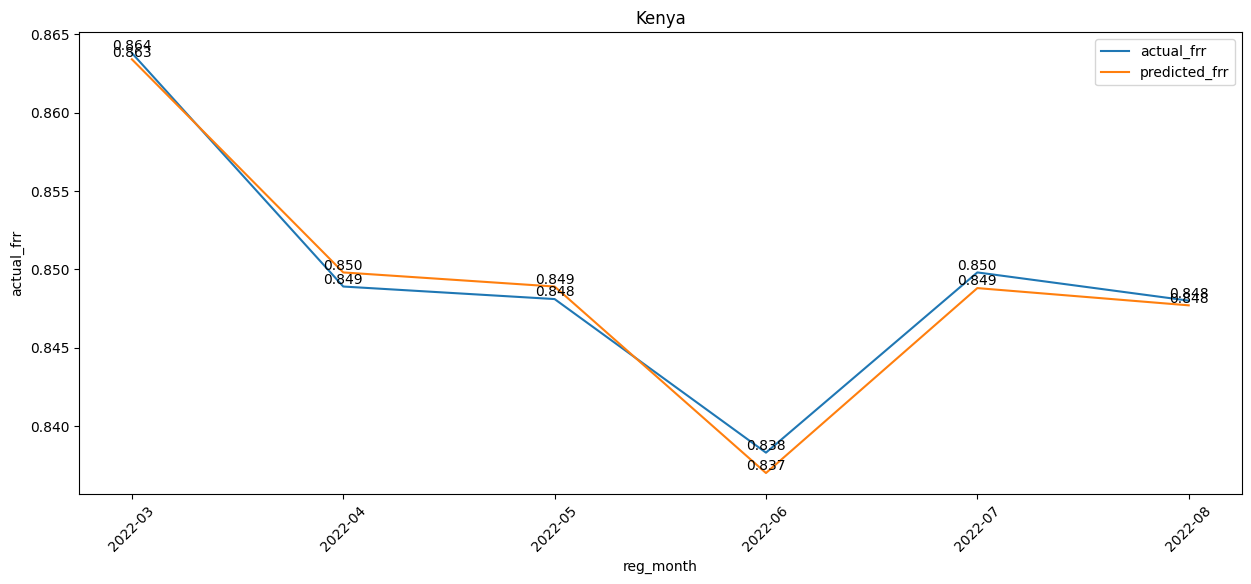

-0.002


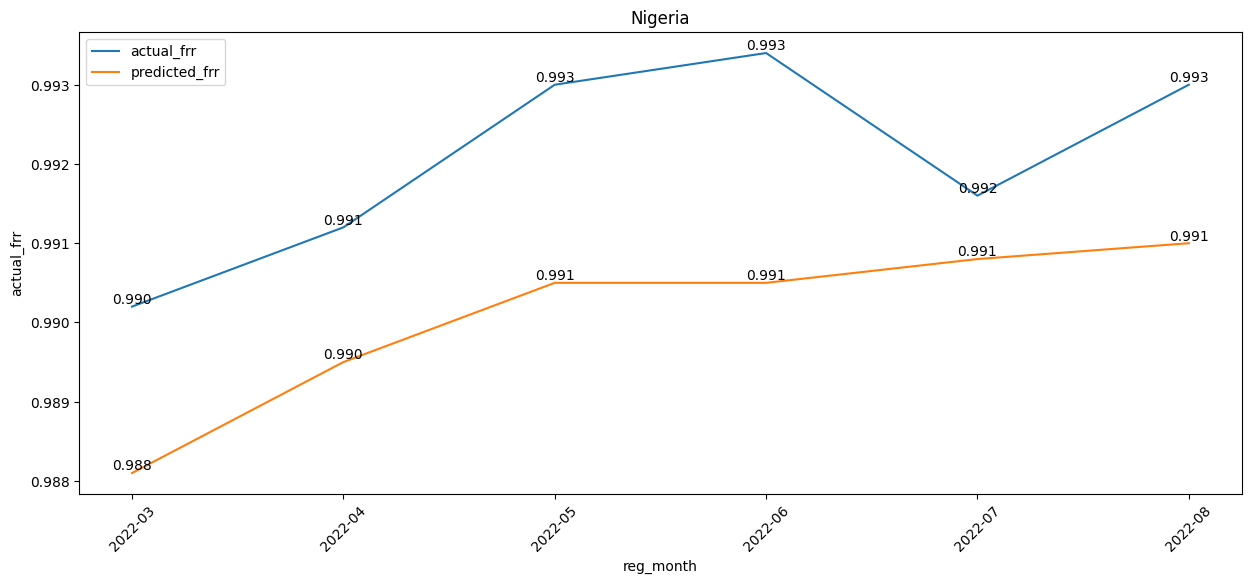

0.0088


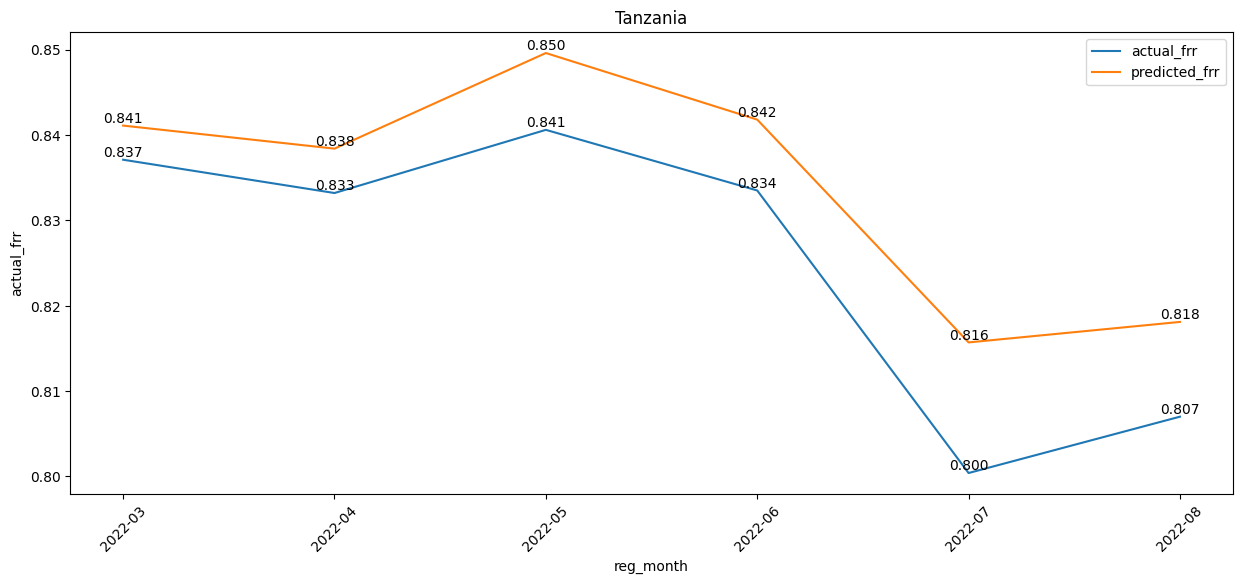

0.0188


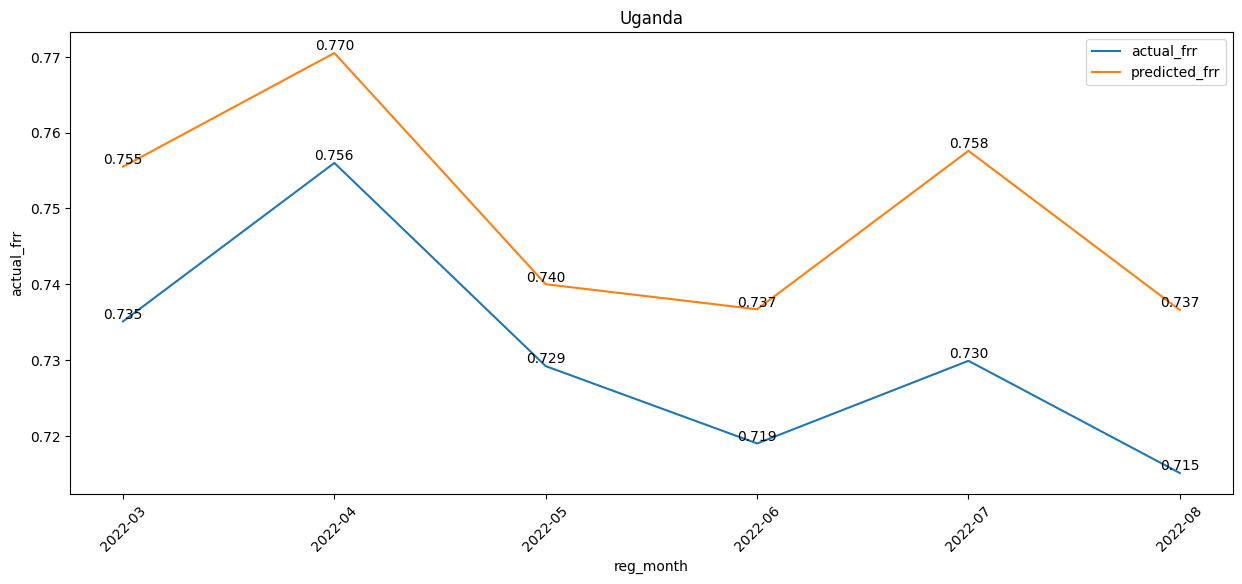

-0.0099


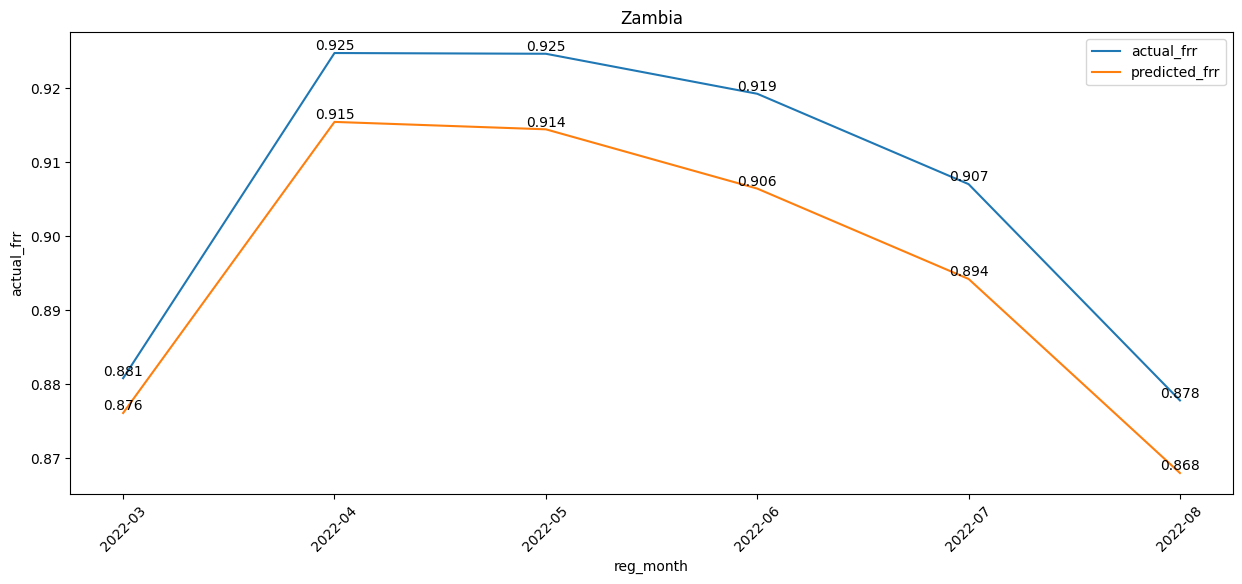

In [77]:
for country in countries:
    plt.figure(figsize=(15, 6))
    subset = df_country[(df_country.country==country)]
    deviation = (subset.predicted_frr - subset.actual_frr).mean().round(4)
    print(deviation)
    ax = sns.lineplot(data=subset, x="reg_month", y="actual_frr", label="actual_frr")
    for x, y in zip(subset["reg_month"], subset["actual_frr"]):
        ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    
    ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr", label="predicted_frr")
    for x, y in zip(subset["reg_month"], subset["predicted_frr"]):
        ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(f"{country}")
    plt.legend()
    plt.show()

## Inference

In [78]:
df_sep = pd.read_csv('../data/KPIs_data_processed_2025-08-01.csv',low_memory=False)#.rename({"cohort_age_backtesting": "cohort_age"}, axis=1)
print(df_sep.shape)

(1178935, 89)


In [79]:
df_sep = df_sep[df_sep.backtesting_limit==360]

In [80]:
df_sep_processed = make_view(df_sep, max_bt=df_sep["cohort_age"].max())

KeyError: 'cohort_age'

In [35]:
df_sep_processed

,accounts_group,count_units,avg_planned_repayment_days,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age,avg_upfront_price_usd,avg_unlock_price_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,bt_present_30,bt_present_60,bt_present_90,bt_present_180,bt_present_270,bt_present_360,bt_present_450,bt_present_540,bt_present_630,bt_present_720
1015090,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,57,77,2016-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,114,720,7.0,30.0,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,1,1,1,1,1,1,1,1,1,1
1015091,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,18,77,2016-02,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,113,720,7.0,30.0,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,1,1,1,1,1,1,1,1,1,1
1015092,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,287,77,2016-02,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,113,720,7.0,30.0,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0.386760,0.268293,0.188153,0.163763,0.153310,0.128920,0.108014,0.062718,1,1,1,1,1,1,1,1,1,1
1015093,2016-03_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,114,77,2016-03,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,112,720,7.0,30.0,0.341451,0.566825,0.706045,

In [36]:
X_sep = df_sep_processed.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)

In [37]:
y_pred_sep = bst.predict(X_sep)

In [38]:
df_sep["predicted_frr"] = y_pred_sep

In [39]:
len(y_pred_sep)

163845

In [40]:
df_sep["date_uploaded"] = "2025-09-01"
df_sep["date_uploaded"] = pd.to_datetime(df_sep["date_uploaded"], format="%Y-%m-%d")
df_sep["reg_month"] = pd.to_datetime(df_sep["reg_month"], format="%Y-%m")

In [41]:
df_sep

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age,predicted_frr,date_uploaded
1015090,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.281498,199500.0,1418.445741,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,114,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.979153,2025-09-01
1015091,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.352052,63000.0,447.930234,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,113,152.85,412.1688,412.168800,7.0,30.0,360,720,0.901707,2025-09-01
1015092,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7770.557718,1004500.0,7141.998731,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0.386760,0.268293,0.188153,0.163763,0.

In [42]:
df_sep['predicted_revenue_USD'] = np.round(df_sep['predicted_frr']*df_sep['total_follow_on_revenue_current_usd'],2)

In [43]:
df_sep

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age,predicted_frr,date_uploaded,predicted_revenue_USD
1015090,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.281498,199500.0,1418.445741,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,114,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.979153,2025-09-01,1511.11
1015091,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.352052,63000.0,447.930234,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,113,152.85,412.1688,412.168800,7.0,30.0,360,720,0.901707,2025-09-01,439.45
1015092,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7770.557718,1004500.0,7141.998731,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0

In [44]:
df2 = df_sep.groupby(["country", "reg_month"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_USD", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df2["predicted_frr_updated"] = df2.predicted_fr/df2.total_fr
df2 = df2.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df2 = df2[df2.product_group.isin(products)]
# df2

In [45]:
df2[df2.country=="Kenya"][70:110]

,country,reg_month,count_average,predicted_frr_updated
171,Kenya,2021-11-01,41,0.863471
172,Kenya,2021-12-01,47,0.874138
173,Kenya,2022-01-01,46,0.877349
174,Kenya,2022-02-01,49,0.869656
175,Kenya,2022-03-01,49,0.867732
176,Kenya,2022-04-01,49,0.855741
177,Kenya,2022-05-01,56,0.855545
178,Kenya,2022-06-01,52,0.843855
179,Kenya,2022-07-01,53,0.854303
180,Kenya,2022-08-01,48,0.852388


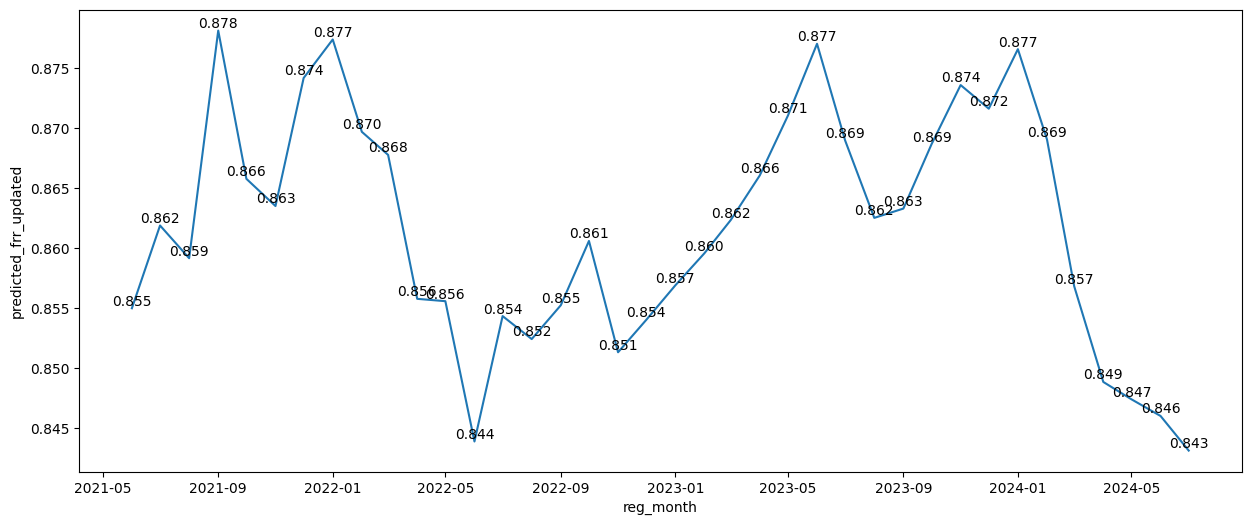

In [46]:
df2["reg_month"] = pd.to_datetime(df2["reg_month"])
plt.figure(figsize=(15, 6))
subset = df2[(df2["country"]=="Kenya") & (df2["reg_month"] >= "2021-06-01")]
ax = sns.lineplot(
    data=subset,
    x="reg_month",
    y="predicted_frr_updated"
)
for x, y in zip(subset["reg_month"], subset["predicted_frr_updated"]):
    ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")


